In [95]:
!pip install emoji


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:

import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import NLTKWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [97]:
# –ø–æ–ª—É—á–∏–º —Å–ø–∏—Å–æ–∫ —Å—Ç–æ–ø —Å–ª–æ–≤.
nltk_stop_words = set(stopwords.words("russian"))
#Lemmatizing the text
wnl = WordNetLemmatizer()

EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']



mlflow_url = 'http://localhost:8080'

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è —ç–º–æ–¥–∂–∏ –≤ —Å–ª–æ–≤–∞
def emojis_words(text):
    
    # –ú–æ–¥—É–ª—å emoji: –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —ç–º–æ–¥–∂–∏ –≤ –∏—Ö —Å–ª–æ–≤–µ—Å–Ω—ã–µ –æ–ø–∏—Å–∞–Ω–∏—è
    clean_text = emoji.demojize(text, delimiters=(" ", " "))
    
    # –†–µ–¥–∞–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Ç–µ–∫—Å—Ç–∞ –ø—É—Ç—ë–º –∑–∞–º–µ–Ω—ã ":" –∏" _", –∞ —Ç–∞–∫ –∂–µ - –ø—É—Ç—ë–º –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –ø—Ä–æ–±–µ–ª–∞ –º–µ–∂–¥—É –æ—Ç–¥–µ–ª—å–Ω—ã–º–∏ —Å–ª–æ–≤–∞–º–∏
    clean_text = clean_text.replace(":", "").replace("_", " ")
    
    return clean_text

# —Ñ—É–Ω–∫—Ü–∏—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏ –∏ –æ—á–∏—Å—Ç–∫–∏ —Ç–µ–∫—Å—Ç–∞.
def cleaner(text :str) -> str:

    # –ü—É–Ω–∫—Ç—É–∞—Ü–∏—è
    text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text)

     #–≠–º–æ—Ç–∏–∫–æ–Ω—ã
    text =emojis_words(text)

    # #unicode
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    # text = re.sub(r'[^\x00-\x7f]',r'',text)

    # url/—Å—Å—ã–ª–∫–∏
    text = re.sub(r'http\S+', r'', text)

    #—Ç–µ–≥–≥–∏—Ä–æ–≤–∞–Ω–∏–µ/nicknames
    text = re.sub('@[A-Za-z0-9_-]+',r'',text)# nickname

    #—Ö—ç—à—Ç–µ–≥–∏
    text = re.sub(r'#([^\s]+)', r'\1', text)

    #—É–¥–∞–ª–∏–º —Ü–∏—Ñ—Ä—ã
    text = ''.join([i for i in text if not i.isdigit()])

    #–ø—Ä–∏–≤–µ–¥–µ–º –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É
    text = text.lower()

    #—É–¥–∞–ª–∏–º —Å—Ç–æ–ø —Å–ª–æ–≤–∞
    stop_words_cleaned = []
    for word in text.split():
      if word not in nltk_stop_words:
        stop_words_cleaned.append(word)

    text = ' '.join(stop_words_cleaned)

    #–ø—Ä–∏–≤–µ–¥–µ–º —Ç–µ–∫—Å—Ç –∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ–π —Ñ–æ—Ä–º–µ.
    text= ' '.join([wnl.lemmatize(word) for word in text.split()])

    return text

# ESKIS  –ò–ú–ë–ü –†–ê–ù

In [98]:
df_train = pd.read_csv('eskis_train.csv')
df_eval = pd.read_csv('eskis_eval.csv')
df_test = pd.read_csv('eskis_test.csv')

In [99]:
df_train = df_train.dropna()
df_eval = df_eval.dropna()
df_test = df_test.dropna()

In [100]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 0 to 1651
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       1650 non-null   object 
 1   Angry      1650 non-null   float64
 2   Disgusted  1650 non-null   float64
 3   Happy      1650 non-null   float64
 4   Neutral    1650 non-null   float64
 5   Sad        1650 non-null   float64
 6   Scared     1650 non-null   float64
 7   Surprised  1650 non-null   float64
dtypes: float64(7), object(1)
memory usage: 116.0+ KB


In [101]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 344
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       343 non-null    object 
 1   Angry      343 non-null    float64
 2   Disgusted  343 non-null    float64
 3   Happy      343 non-null    float64
 4   Neutral    343 non-null    float64
 5   Sad        343 non-null    float64
 6   Scared     343 non-null    float64
 7   Surprised  343 non-null    float64
dtypes: float64(7), object(1)
memory usage: 24.1+ KB


In [102]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 361
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       360 non-null    object 
 1   Angry      360 non-null    float64
 2   Disgusted  360 non-null    float64
 3   Happy      360 non-null    float64
 4   Neutral    360 non-null    float64
 5   Sad        360 non-null    float64
 6   Scared     360 non-null    float64
 7   Surprised  360 non-null    float64
dtypes: float64(7), object(1)
memory usage: 25.3+ KB


In [103]:
#df_train = pd.concat([df_train, df_eval])

In [104]:
#df_train['text'] = df_train['text'].apply(cleaner)
#df_test['text'] = df_test['text'].apply(cleaner)

In [105]:
df_train.head(50)

text  Angry  Disgusted  \
0   –ª–µ–±–µ–¥–µ–≤–∞ —Å–≤–µ—Ç–ª–∞–Ω–∞ —à–µ—Å—Ç–Ω–∞–¥—Ü–∞—Ç–æ–µ –∞–ø—Ä–µ–ª—è –æ–¥–∏–Ω–Ω–∞–¥—Ü...    0.0        0.0   
1   —Ä–∞–¥–∏–æ–≥—Ä–∞–º–º–∞ –¥–ª—è —Å–æ–≤–∏–Ω–∫–∏–Ω–æ–π –Ω–∞–≤–µ—Ä–Ω–æ–µ –ø–æ –±–∞—Ä –∫–æ–¥...    0.0        1.0   
2     –≤—Å–µ–º –¥–æ–±—Ä—ã–π –¥–µ–Ω—å –∫–æ–º–∞–Ω–¥–∏—Ä —ç–∫–∏–ø–∞–∂–∞ –ø–ª—É–± —Ñ–ª–∞–≥ —Ç–∞–∫    0.0        0.0   
3   –≤—Å–µ–º –¥–æ–±—Ä—ã–π –¥–µ–Ω—å –∫–æ–º–∞–Ω–¥–∏—Ä —ç–∫–∏–ø–∞–∂–∞ –≤–æ–ø—Ä–æ—Å—ã –≤–æ–∑–Ω...    0.0        0.0   
4   –≤ —Ç–æ–º —á–∏—Å–ª–µ –Ω–∞ –ø–∞–ø–∫–µ –≤ —Ç–∏–ø–∏ —Ä–µ–≥–ª–∞–º–µ–Ω—Ç–∞ —Å–≤—è–∑–∏ –ø...    0.0        0.0   
5          –º—ã –Ω–µ –Ω–∞—à–ª–∏ –∞ —è—á–µ–π–∫—É –∫–æ—Ç–æ—Ä–∞—è –≤ –ø—Ä–µ–¥–ø—Ä–∏—è—Ç–∏–∏    0.0        0.0   
6      –æ—Ç–º–µ—á–µ–Ω–æ –±–∞—Ä–∫–æ–¥–æ–º –Ω–∞ –Ω–µ–º –Ω–∞ –ø–∞–∫–µ—Ç–µ –Ω–µ—Ç –±–∞—Ä–∫–æ–¥–∞    0.0        0.0   
7   –∞–¥—Ä–µ—Å–∞—Ç–æ–≤ —á—Ç–æ–±—ã –Ω–µ –∏—Å–∫–∞—Ç—å –∫–∞–∂–¥—ã–π —Ä–∞–∑ –µ–≥–æ –∏–∑ —Ñ—Ç...    0.0        0.0   
8   —Å–∞–º–æ–µ –≥–ª–∞–≤–Ω–æ–µ –º—ã —Å–µ–π—á–∞—Å –¥–æ–ª–∂–Ω—ã –æ–±–µ–¥–∞—Ç—å –º—ã –Ω–µ –Ω...    0.0        0.0   
9   –≤–∏–ª–∫–∏ –∏ –≤—Å–µ –≤ –Ω–æ–º–µ–Ω–∫–ª–∞—Ç—É—Ä–µ –≤ –±–∞–∑–µ —Ç–∞—Ä–µ–ª–æ–∫ —Ç–æ–∂–µ...    0.0        0.0   
10             –¥–æ–±—Ä—ã–π –¥–µ–Ω—å –∫–æ–º–∞–Ω–¥–∏—Ä —ç–∫–∏–ø–∞–∂–∞ –ø–æ –ø–æ–≤–æ–¥—É    0.0        0.0   
11  –≥—Ä–∞–º–º—ã –æ—Ç –∞–ª–µ–∫—Å–∞–Ω–¥—Ä—ã —Å–∞–≤–∏–Ω–∫–∏–Ω–æ–π –º—ã —Å–æ–æ–±—â–∏–ª–∏ –ø–æ...    0.0        0.0   
12  –∏ –ª–µ–∂–∏—Ç –ø–æ–Ω—è–ª–∏ –≥–¥–µ —ç—Ç–æ –ª–µ–∂–∏—Ç –Ω–æ —Å–ø–∏—Å–∞—Ç—å –∏–∑ —Å–∏—Å...    0.0        0.0   
13  –¥–æ–∫–ª–∞–¥–æ–º –ø–æ –ø–æ–≤–æ–¥—É –ø—Ä–æ–≤–µ–¥–µ–Ω–∏—è –≥—Ä—É–ø–ø–æ–≤–æ–π –¥–∏—Å–∫—É—Å...    0.0        0.0   
14  –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –æ–∂–∏–≤–ª–µ–Ω–Ω–æ –∏ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ –≤—Å–µ–≥–æ –¥–æ–±—Ä–æ–≥–æ...    0.0        0.0   
15  –Ω–∞–ø–æ–ª–Ω–∏–º –µ–≥–æ –µ—â–µ —Å–µ–π—á–∞—Å —à–ª—é–∑ —Å –º—É—Å–æ—Ä–æ–º –∏ –±—É–¥–µ—Ç...    0.0        0.0   
16                     —Ü—É–ø–Ω–µ–∫ —ç—Å–∫–∏–∑ –¥–ª—è —à–µ—Å—Ç–æ–π –¥–ª—è–º–∏–∞    0.0        0.0   
17  –æ–Ω–∞ –Ω—É –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —Å–ª–µ–ø–∏—Ç –≥–ª–∞–∑–∞ –≥–ª–∞–∑–∞ –æ—Ç —ç—Ç–æ–≥–æ ...    0.0        0.0   
18  —É –Ω–∞—Å –±—É–¥—É—Ç —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –º–µ—Ç–æ–¥–∏–∫–∏ —è –Ω–µ –∑–Ω–∞—é...    0.0        0.0   
19  –µ—Å—Ä–∏–¥–µ—Ä–∞ —Ç–æ –∫–æ–Ω–µ—á–Ω–æ –º—ã –±—É–¥–µ–º —ç—Ç–æ –¥–µ–ª–∞—Ç—å –≤—Å–µ –≤–∏...    0.0        0.0   
20  —Ü–æ–≤—ã–π –¥–∞ —É –Ω–∞—Å –≤—Å–µ –µ—Å—Ç—å —É –Ω–∞—Å –≤—Å–µ –Ω–∞ –º–µ—Å—Ç–∞—Ö –ø—Ä...    0.0        0.0   
21  –¥–ª—è —Å–∞—à–∏ —Å–∞–≤–∏–Ω–∫–∏–Ω–æ–π –ø–æ –ø–æ–≤–æ–¥—É –ø–∞—Ä–∫–æ–¥–∞  –Ω–∞–º —Å–æ–∑...    0.0        0.0   
22        –æ—Ç–¥–µ–ª—å–Ω—É—é —è—á–µ–π–∫—É –∫–∞–∫ –±—ã –≤ —Å–∫–ª–∞–¥–µ —á—Ç–æ–±—ã –º–æ—á—å    0.0        0.0   
23  –Ω—É –∏–∑–≤–ª–µ—á—å –∫–∞–∫ –±—ã –∏ –Ω–∞—á–∞—Ç—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –≤–µ—â–∏ –æ...    0.0        0.0   
24  –∏–ª–∏ –±—ã–ª–æ –±—ã –≤—ã—Å–ª–∞—Ç—å –æ—Ç–¥–µ–ª—å–Ω—ã–µ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏–∏ –¥–ª—è —Ç...    0.0        0.0   
25  –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –≤–µ—â–µ–π –Ω–∞–º–∏ –∏ –≤—Ç–æ—Ä–æ–π –≤–æ–ø—Ä–æ—Å –ø–æ –ø–æ...    0.0        0.0   
26  –Ω–∞–∑–≤–∞–Ω–∏–µ –Ω–æ —É –Ω–µ–≥–æ –Ω–µ –±—ã–ª–æ —à—Ç—Ä–∏—Ö –∫–æ–¥–∞ –æ–ø—è—Ç—å –∂–µ...    0.0        0.0   
27  –æ—Ç–º–µ—Ç–∏—Ç—å —á—Ç–æ –æ–Ω–æ –±—ã–ª–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–æ –≤–æ—Ç —á—Ç–æ –≤ —Ç...    0.0        0.0   
28  —Ñ —Å –≥–æ–≤—è–¥–∏–Ω–æ–π –≥–∞–ª–∞ –≥–∞–ª–∞ –Ω–µ–ø–æ–Ω—è—Ç–Ω–æ —á—Ç–æ –ø–æ–¥ —ç—Ç–∏–º...    0.0        0.0   
29  –∞–∑—É–º–µ–≤–∞–µ—Ç—Å—è –∏ —á—Ç–æ —Å —ç—Ç–∏–º –¥–µ–ª–∞—Ç—å –ø–æ—Ç–æ–º—É —á—Ç–æ —É–∂–∏...    0.0        0.0   
30   –Ω–∞—á–∏–Ω–∞–µ–º –≤–µ—á–µ—Ä–Ω—é—é –¥–∏–ø–∏—Å–∏ –∏—Å–ø—ã—Ç–∞—Ç–µ–ª—å –µ –æ–¥–∏–Ω –≤—Ä–µ–º—è    0.0        1.0   
31           —Ç–∞–∫ –ª–∞–¥–Ω–æ –¥–∞—Ç–∞ —à–µ—Å—Ç–Ω–∞–¥—Ü–∞—Ç–æ–µ –∞–ø—Ä–µ–ª—è –≤—Ä–µ–º—è    0.0        1.0   
32  —Ö–æ—Ä–æ—à–∞—è –Ω–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –ø—Ä–æ–≥—Ä–∞–º–º–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω...    0.0        1.0   
33  –ø–æ–ª—É—á–µ–Ω –¥–≤–µ —Ä–∞–¥–∏–æ–≥—Ä–∞–º–º—ã –æ–¥–Ω–∞ –ø–æ –º–µ—Ç–æ–¥–∏–∫–µ –ø—Å –¥–≤...    0.0        1.0   
34  —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ –±—É–¥–µ—Ç –Ω–µ–∫–æ—Ç–æ—Ä–æ–µ —Ä–∞—Å—Ç—è–∂–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω...    0.0        1.0   
35               

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, classification_report, multilabel_confusion_matrix
import numpy as np

In [107]:
# 1. –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
X_train = df_train['text']
y_train = df_train[EMOTIONS]
X_test = df_test['text']
y_test = df_test[EMOTIONS]


In [108]:
# 2. –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [109]:

# 4. –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, class_weight='balanced')
).fit(X_train, y_train)

# 5. –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# 6. –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞
print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=EMOTIONS))


Hamming Loss: 0.1054

Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         0
   Disgusted       0.22      0.30      0.25        37
       Happy       0.20      0.27      0.23        22
     Neutral       0.95      0.93      0.94       327
         Sad       0.09      0.13      0.11        15
      Scared       0.00      0.00      0.00         0
   Surprised       0.32      0.51      0.39        47

   micro avg       0.69      0.78      0.73       448
   macro avg       0.25      0.31      0.28       448
weighted avg       0.76      0.78      0.77       448
 samples avg       0.77      0.83      0.76       448



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

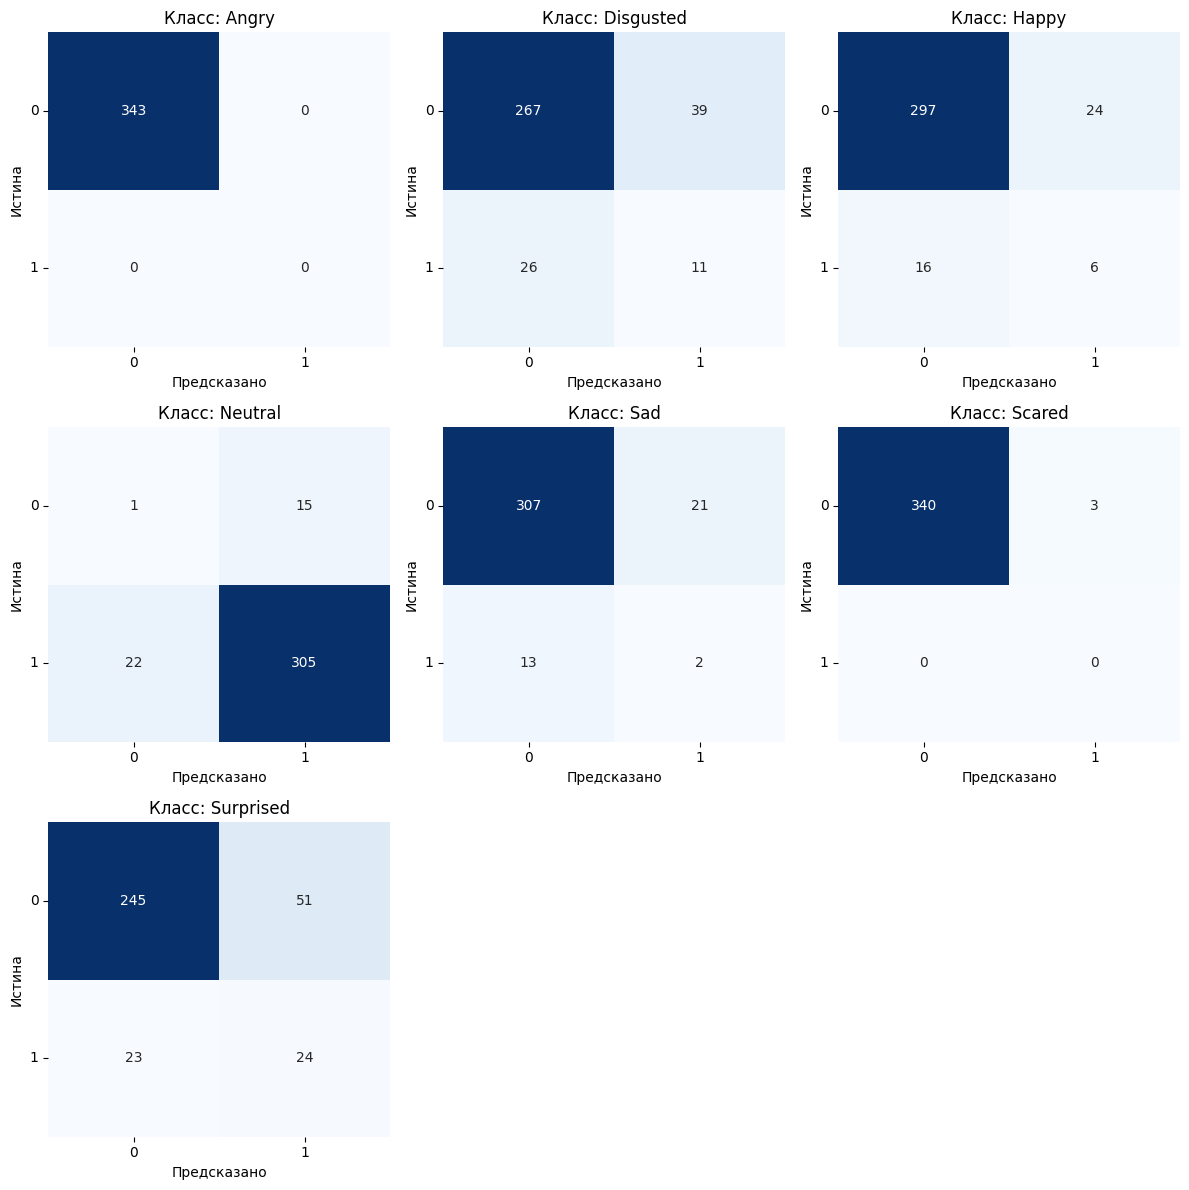

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º DataFrame —Å –∏—Å—Ç–∏–Ω–Ω—ã–º–∏ –º–µ—Ç–∫–∞–º–∏ –≤ numpy-–º–∞—Å—Å–∏–≤.
# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ y_test –∏ y_pred –∏–º–µ—é—Ç —Ñ–æ—Ä–º—É (n_samples, n_classes)
y_true_array = y_test.to_numpy()
y_pred_array = y_pred  # –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ y_pred —É–∂–µ –≤ –Ω—É–∂–Ω–æ–º –≤–∏–¥–µ

# –ü–æ–ª—É—á–∞–µ–º –∏–º–µ–Ω–∞ –∫–ª–∞—Å—Å–æ–≤ –∏–∑ —Å—Ç–æ–ª–±—Ü–æ–≤ DataFrame (–µ—Å–ª–∏ –æ–Ω–∏ –µ—Å—Ç—å)
class_names = y_test.columns.tolist()

# –í—ã—á–∏—Å–ª—è–µ–º –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω—É—é confusion matrix –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
mcm = multilabel_confusion_matrix(y_true_array, y_pred_array)

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤ –∏ –Ω–∞—Å—Ç—Ä–∞–∏–≤–∞–µ–º –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–∏
n_classes = len(class_names)
n_cols = 3  # –º–æ–∂–Ω–æ –∏–∑–º–µ–Ω–∏—Ç—å —á–∏—Å–ª–æ —Å—Ç–æ–ª–±—Ü–æ–≤
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, (cm, class_name) in enumerate(zip(mcm, class_names)):
    # cm –∏–º–µ–µ—Ç —Ñ–æ—Ä–º—É 2x2 –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞: [[TN, FP], [FN, TP]]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"–ö–ª–∞—Å—Å: {class_name}")
    axes[i].set_xlabel("–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–æ")
    axes[i].set_ylabel("–ò—Å—Ç–∏–Ω–∞")
    axes[i].set_xticklabels(["0", "1"], rotation=0)
    axes[i].set_yticklabels(["0", "1"], rotation=0)

# –ï—Å–ª–∏ –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–æ–≤ –±–æ–ª—å—à–µ, —á–µ–º –∫–ª–∞—Å—Å–æ–≤, —Å–∫—Ä—ã–≤–∞–µ–º –ª–∏—à–Ω–∏–µ –æ—Å–∏
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [111]:
from sklearn.metrics import f1_score
# define which metrics to compute for evaluation
def compute_metrics(p):
    predictions, labels = p
    f1_micro = f1_score(labels, predictions > 0, average = 'micro')
    f1_macro = f1_score(labels, predictions > 0, average = 'macro')
    f1_weighted = f1_score(labels, predictions > 0, average = 'weighted')
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [112]:

import torch
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # –ò–∑–≤–ª–µ–∫–∞–µ–º –º–µ—Ç–∫–∏ –∏ –ø—Ä–∏–≤–æ–¥–∏–º –∏—Ö –∫ float (BCEWithLogitsLoss –æ–∂–∏–¥–∞–µ—Ç —Ç–µ–Ω–∑–æ—Ä—ã float)
        labels = inputs.get("labels")
        if labels is not None:
            labels = labels.float()
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [121]:
BASE_MODEL = 'DeepPavlov/rubert-base-cased' #'sergeyzh/rubert-tiny-turbo'
mlflow_url = 'http://localhost:8080'

EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']
import mlflow
import numpy as np
import pandas as pd

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from transformers.integrations import MLflowCallback
from transformers import TrainerCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split



mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment(f"ESKIS {BASE_MODEL} trans")
mlflow.enable_system_metrics_logging()

#Callback –¥–ª—è –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –º–µ—Ç—Ä–∏–∫ –≤ MLflow
class MLflowLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            for key, value in logs.items():
                mlflow.log_metric(key, value, step=state.global_step)
        return control



df_train["labels"] = df_train[EMOTIONS].values.tolist()
df_eval["labels"] = df_eval[EMOTIONS].values.tolist()


# –°–æ–∑–¥–∞–Ω–∏–µ –æ–±—ä–µ–∫—Ç–æ–≤ HuggingFace Dataset –∏–∑ pandas DataFrame
train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
val_dataset = Dataset.from_pandas(df_eval.reset_index(drop=True))

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –∏ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tokenize_function(example):
    tokenized = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    tokenized["labels"] = example['labels']
    return tokenized

train_dataset = train_dataset.map(tokenize_function, batched=False)
val_dataset = val_dataset.map(tokenize_function, batched=False)

# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ñ–æ—Ä–º–∞—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –¥–ª—è –º–Ω–æ–≥–æ–∫–ª–∞—Å—Å–æ–≤–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (7 –∫–ª–∞—Å—Å–æ–≤)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=7,problem_type = "multi_label_classification")

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –æ–±—É—á–µ–Ω–∏—è —Å –ø—Ä–æ–º–µ–∂—É—Ç–æ—á–Ω—ã–º –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ–º (–∫–∞–∂–¥—ã–µ 50 —à–∞–≥–æ–≤)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    learning_rate=2e-7,
    logging_dir='./logs',
    report_to=["mlflow"],  # –õ–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ —Ç–æ–ª—å–∫–æ –≤ MLflow
)




# –ó–∞–ø—É—Å–∫ MLflow run
mlflow.start_run()

#–°–æ–∑–¥–∞–Ω–∏–µ Trainer —Å —É–∫–∞–∑–∞–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ –∏ callback'–∞–º–∏
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MLflowCallback(), MLflowLoggingCallback()],
)

#–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
trainer.train()

#–û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–º –Ω–∞–±–æ—Ä–µ
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# 14. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –≤ MLflow
# mlflow.pytorch.log_model(model, "model")
# mlflow.pytorch.save_model(model,'./sm1')
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
#mlflow.transformers.save_model(classifier,'./')
mlflow.transformers.log_model(classifier,'model')

mlflow.end_run()

# 15. –ò–Ω—Ñ–µ—Ä–µ–Ω—Å: —Å–æ–∑–¥–∞–Ω–∏–µ pipeline –∏ –ø—Ä–∏–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
example_text = "—è —Å—á–∞—Å—Ç–ª–∏–≤!"
prediction = classifier(example_text)
print("Prediction:", prediction)



Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(
2025/03/31 20:22:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
You are adding a <class 'transformers.integrations.integration_utils.MLflowCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
MLflowCallback


Device set to use cuda:0


Evaluation results: {'eval_loss': 0.2602388262748718, 'eval_f1_micro': 0.8037602820211516, 'eval_f1_macro': 0.1391941391941392, 'eval_f1_weighted': 0.6786777377408741, 'eval_runtime': 0.9016, 'eval_samples_per_second': 399.312, 'eval_steps_per_second': 49.914, 'epoch': 100.0}


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
2025/03/31 20:45:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/31 20:45:37 WARNING mlflow.utils.environment: On Windows, timeout is not supported for model requirement inference. Therefore, the operation is not bound by a timeout and may hang indefinitely. If it hangs, please consider specifying the signature manually.
2025/03/31 20:46:06 INFO mlf

Prediction: [[{'label': 'LABEL_0', 'score': 0.10688259452581406}, {'label': 'LABEL_1', 'score': 0.16936425864696503}, {'label': 'LABEL_2', 'score': 0.14908507466316223}, {'label': 'LABEL_3', 'score': 0.8794889450073242}, {'label': 'LABEL_4', 'score': 0.14453987777233124}, {'label': 'LABEL_5', 'score': 0.11141800135374069}, {'label': 'LABEL_6', 'score': 0.19677318632602692}]]


In [114]:
# 15. –ò–Ω—Ñ–µ—Ä–µ–Ω—Å: —Å–æ–∑–¥–∞–Ω–∏–µ pipeline –∏ –ø—Ä–∏–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
example_text = "—è —Å—á–∞—Å—Ç–ª–∏–≤!"
prediction = classifier(example_text)
print("Prediction:", prediction)


Device set to use cuda:0


Prediction: [[{'label': 'LABEL_0', 'score': 0.10864850133657455}, {'label': 'LABEL_1', 'score': 0.17558695375919342}, {'label': 'LABEL_2', 'score': 0.143351748585701}, {'label': 'LABEL_3', 'score': 0.8814486265182495}, {'label': 'LABEL_4', 'score': 0.15284286439418793}, {'label': 'LABEL_5', 'score': 0.10101520270109177}, {'label': 'LABEL_6', 'score': 0.19540946185588837}]]


In [115]:
mlflow.end_run()

Device set to use cuda:0
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         0
   Disgusted       0.00      0.00      0.00        37
       Happy       0.00      0.00      0.00        22
     Neutral       0.95      1.00      0.98       327
         Sad       0.00      0.00      0.00        15
      Scared       0.00      0.00      0.00         0
   Surprised       1.00      0.02      0.04        47

   micro avg       0.95      0.73      0.83       448
   macro avg       0.28      0.15      0.15       448
weighted avg       0.80      0.73      0.72       448
 samples avg       0.95      0.81      0.85       448



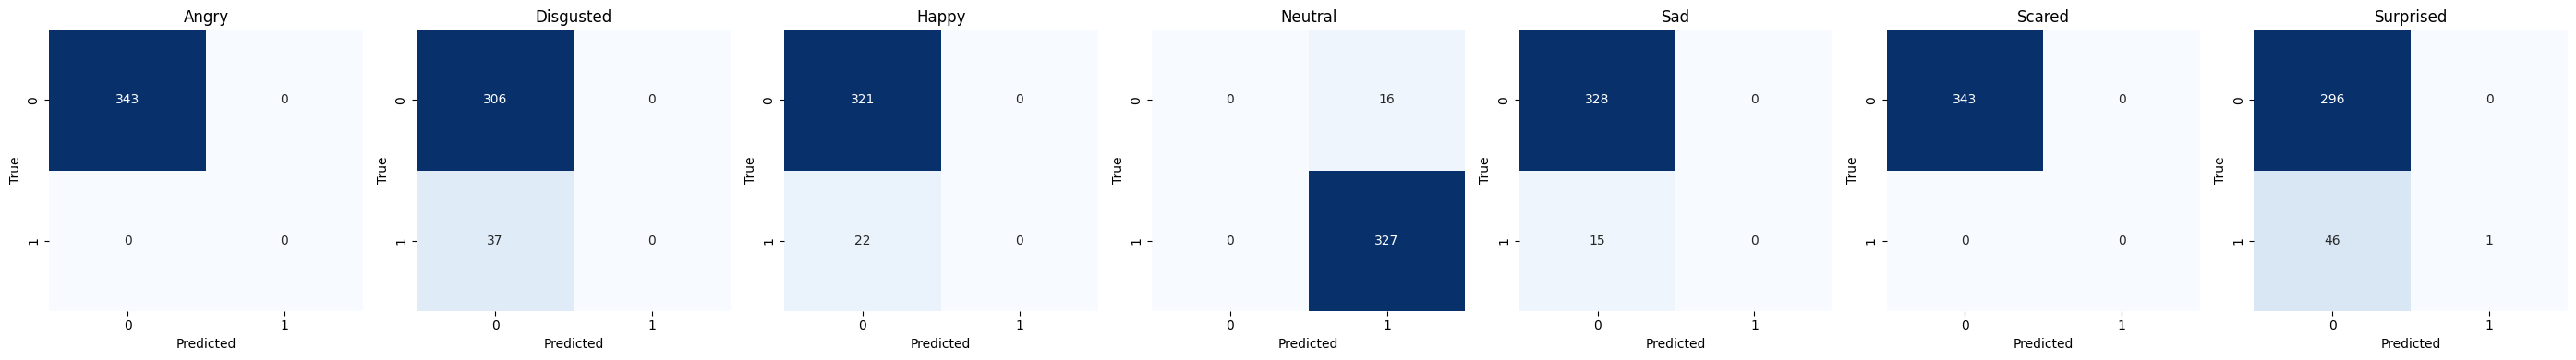

In [122]:
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# –®–∞–≥ 1: –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–ø–∏—Å–æ–∫ —ç–º–æ—Ü–∏–π (–∫–ª–∞—Å—Å–æ–≤)
EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']

# –®–∞–≥ 2: –°–æ–∑–¥–∞—ë–º —Å—Ç–æ–ª–±–µ—Ü "labels" —Å –≤–µ–∫—Ç–æ—Ä–æ–º 0/1 –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏
df_test["labels"] = df_test[EMOTIONS].values.tolist()

# –®–∞–≥ 3: –°–æ–∑–¥–∞—ë–º pipeline –¥–ª—è –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
# (–ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ model –∏ tokenizer —É–∂–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã/–æ–±—É—á–µ–Ω—ã)
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

# –°–ø–∏—Å–∫–∏ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –∏ –∏—Å—Ç–∏–Ω–Ω—ã—Ö –º–µ—Ç–æ–∫
predictions = []
true_labels = []

# –®–∞–≥ 4: –ò–Ω—Ñ–µ—Ä–µ–Ω—Å –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ –≤ df_test
for _, row in df_test.iterrows():
    text = row["text"]
    # –ò—Å—Ç–∏–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ (—Å–ø–∏—Å–æ–∫ –∏–∑ 7 —ç–ª–µ–º–µ–Ω—Ç–æ–≤: 0 –∏–ª–∏ 1)
    true_labels.append(row["labels"])
    
    # –í—ã–∑—ã–≤–∞–µ–º pipeline –Ω–∞ —Ç–µ–∫—Å—Ç
    outputs = classifier(text)
    # outputs –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–ø–∏—Å–∫–æ–º —Å–ª–æ–≤–∞—Ä–µ–π –∏–ª–∏ —Å–ø–∏—Å–∫–æ–º —Å–ø–∏—Å–∫–æ–≤ —Å–ª–æ–≤–∞—Ä–µ–π
    # –ï—Å–ª–∏ –≤–µ—Ä–Ω—É–ª—Å—è —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤, –±–µ—Ä—ë–º –ø–µ—Ä–≤—ã–π —ç–ª–µ–º–µ–Ω—Ç
    if isinstance(outputs[0], list):
        outputs = outputs[0]
        
    # –ò–∑–≤–ª–µ–∫–∞–µ–º score –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É
    scores = [o["score"] for o in outputs]
    # –ë–∏–Ω–∞—Ä–∏–∑—É–µ–º –ø–æ –ø–æ—Ä–æ–≥—É 0.5
    pred = [1 if s > 0.2 else 0 for s in scores]
    predictions.append(pred)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ numpy –º–∞—Å—Å–∏–≤—ã –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞
y_true = np.array(true_labels)  # shape (num_samples, 7)
y_pred = np.array(predictions)  # shape (num_samples, 7)

# –®–∞–≥ 5: –í—ã–≤–æ–¥–∏–º –æ—Ç—á—ë—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (precision, recall, f1-score) –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
report = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=0)
print("Classification Report:\n", report)

# –®–∞–≥ 6: –í—ã—á–∏—Å–ª—è–µ–º –∏ –≤–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω—ã–µ confusion matrices
mcm = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, len(EMOTIONS), figsize=(4 * len(EMOTIONS), 4))
if len(EMOTIONS) == 1:
    axes = [axes]  # –ï—Å–ª–∏ –≤–¥—Ä—É–≥ –æ–¥–∏–Ω –∫–ª–∞—Å—Å

for i, (cm, emotion) in enumerate(zip(mcm, EMOTIONS)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(emotion)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()


Device set to use cuda:0
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

  no emotion       0.95      0.50      0.66       327
         joy       0.13      0.77      0.23        22
     sadness       0.03      0.07      0.04        15
    surprise       0.08      0.02      0.03        47
        fear       0.00      0.00      0.00         0
       anger       0.09      0.03      0.04        37

   micro avg       0.50      0.41      0.45       448
   macro avg       0.21      0.23      0.17       448
weighted avg       0.72      0.41      0.50       448
 samples avg       0.51      0.44      0.46       448



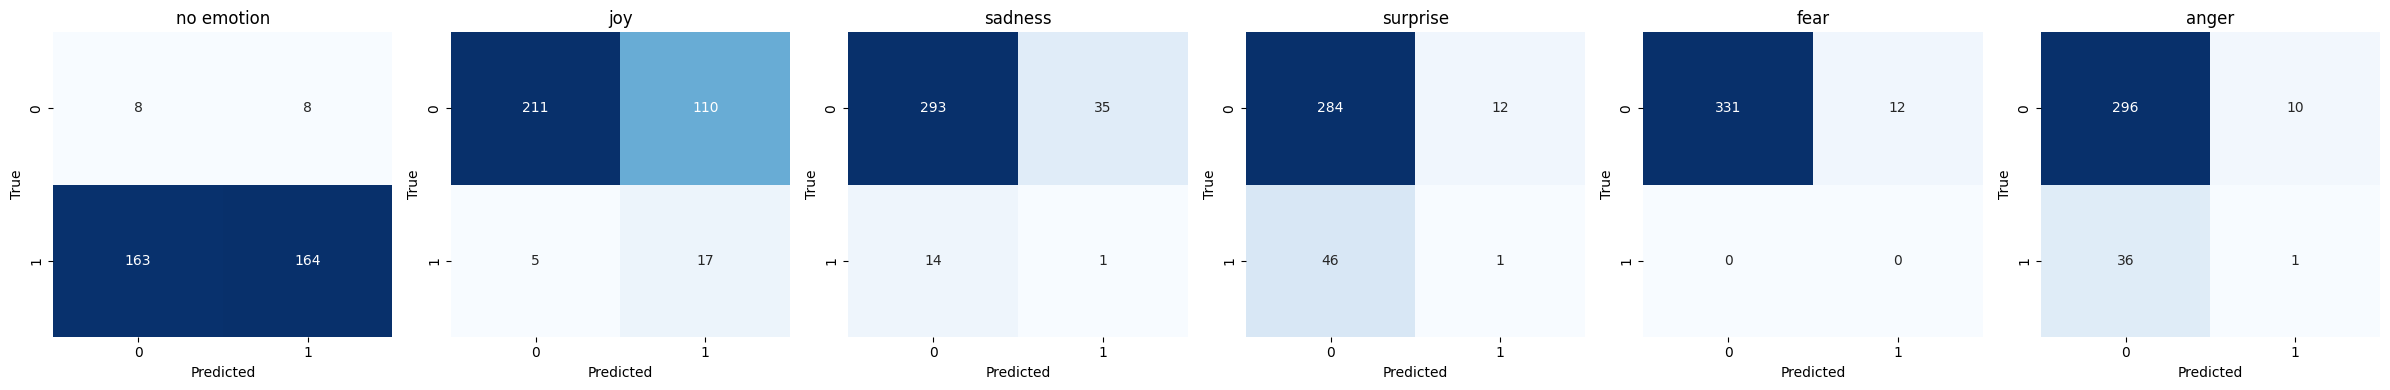

Device set to use cuda:0


Prediction: [[{'label': 'no_emotion', 'score': 0.01408832985907793}, {'label': 'joy', 'score': 0.9835302233695984}, {'label': 'sadness', 'score': 0.01516492385417223}, {'label': 'surprise', 'score': 0.012370861135423183}, {'label': 'fear', 'score': 0.007638067472726107}, {'label': 'anger', 'score': 0.010831735096871853}]]


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [133]:
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# –®–∞–≥ 1: –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–ø–∏—Å–æ–∫ —ç–º–æ—Ü–∏–π (–∫–ª–∞—Å—Å–æ–≤)
EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']
df_test = pd.read_csv('eskis_test.csv')


# –ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏–º, —á—Ç–æ df_test —É–∂–µ –∑–∞–≥—Ä—É–∂–µ–Ω –∏ –∏–º–µ–µ—Ç —Å—Ç–æ–ª–±—Ü—ã:
# ["text", "Angry", "Disgusted", "Happy", "Neutral", "Sad", "Scared", "Surprised"]

# 1. –°–æ–∑–¥–∞—ë–º –Ω–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã, –æ–±—ä–µ–¥–∏–Ω—è—è "Angry" –∏ "Disgusted" -> "anger"
df_test["anger"] = (
    (df_test["Angry"] == 1) | (df_test["Disgusted"] == 1)
).astype(int)

# 2. –û—Å—Ç–∞–ª—å–Ω—ã–µ —ç–º–æ—Ü–∏–∏ –Ω–∞–ø—Ä—è–º—É—é –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º:
df_test["no emotion"] = df_test["Neutral"]
df_test["joy"] = df_test["Happy"]
df_test["sadness"] = df_test["Sad"]
df_test["surprise"] = df_test["Surprised"]
df_test["fear"] = df_test["Scared"]

# 3. (–û–ø—Ü–∏–æ–Ω–∞–ª—å–Ω–æ) –£–¥–∞–ª—è–µ–º —Å—Ç–∞—Ä—ã–µ —Å—Ç–æ–ª–±—Ü—ã, –µ—Å–ª–∏ –æ–Ω–∏ –±–æ–ª—å—à–µ –Ω–µ –Ω—É–∂–Ω—ã:
df_test.drop(columns=["Angry","Disgusted","Happy","Neutral","Sad","Scared","Surprised"], inplace=True)

# 4. –§–æ—Ä–º–∏—Ä—É–µ–º –Ω–æ–≤—ã–π —Å–ø–∏—Å–æ–∫ —ç–º–æ—Ü–∏–π (—Å —É—á—ë—Ç–æ–º –Ω–æ–≤–æ–π —Å—Ö–µ–º—ã)
EMOTIONS = ["no emotion", "joy", "sadness", "surprise", "fear", "anger"]

# 5. –°–æ–∑–¥–∞—ë–º —Å—Ç–æ–ª–±–µ—Ü "labels" —Å–æ —Å–ø–∏—Å–∫–æ–º 0/1 –¥–ª—è –∫–∞–∂–¥–æ–π –Ω–æ–≤–æ–π —ç–º–æ—Ü–∏–∏
df_test["labels"] = df_test[EMOTIONS].values.tolist()

# –¢–µ–ø–µ—Ä—å df_test —Å–æ–¥–µ—Ä–∂–∏—Ç:
# - "text"
# - "anger", "no_emotion", "joy", "sadness", "surprise", "fear"
# - "labels" (—Å–ø–∏—Å–æ–∫ –∏–∑ 6 –∑–Ω–∞—á–µ–Ω–∏–π 0/1)




# –®–∞–≥ 2: –°–æ–∑–¥–∞—ë–º —Å—Ç–æ–ª–±–µ—Ü "labels" —Å –≤–µ–∫—Ç–æ—Ä–æ–º 0/1 –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏
#df_test["labels"] = df_test[EMOTIONS].values.tolist()

# –®–∞–≥ 3: –°–æ–∑–¥–∞—ë–º pipeline –¥–ª—è –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
# (–ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ model –∏ tokenizer —É–∂–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã/–æ–±—É—á–µ–Ω—ã)
classifier = pipeline(
    "text-classification",
    model='cointegrated/rubert-tiny2-cedr-emotion-detection',
    return_all_scores=True
)

# –°–ø–∏—Å–∫–∏ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –∏ –∏—Å—Ç–∏–Ω–Ω—ã—Ö –º–µ—Ç–æ–∫
predictions = []
true_labels = []

# –®–∞–≥ 4: –ò–Ω—Ñ–µ—Ä–µ–Ω—Å –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ –≤ df_test
for _, row in df_test.iterrows():
    text = row["text"]
    # –ò—Å—Ç–∏–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ (—Å–ø–∏—Å–æ–∫ –∏–∑ 7 —ç–ª–µ–º–µ–Ω—Ç–æ–≤: 0 –∏–ª–∏ 1)
    true_labels.append(row["labels"])
    
    # –í—ã–∑—ã–≤–∞–µ–º pipeline –Ω–∞ —Ç–µ–∫—Å—Ç
    outputs = classifier(text)
    # outputs –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–ø–∏—Å–∫–æ–º —Å–ª–æ–≤–∞—Ä–µ–π –∏–ª–∏ —Å–ø–∏—Å–∫–æ–º —Å–ø–∏—Å–∫–æ–≤ —Å–ª–æ–≤–∞—Ä–µ–π
    # –ï—Å–ª–∏ –≤–µ—Ä–Ω—É–ª—Å—è —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤, –±–µ—Ä—ë–º –ø–µ—Ä–≤—ã–π —ç–ª–µ–º–µ–Ω—Ç
    if isinstance(outputs[0], list):
        outputs = outputs[0]
        
    # –ò–∑–≤–ª–µ–∫–∞–µ–º score –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É
    scores = [o["score"] for o in outputs]
    # –ë–∏–Ω–∞—Ä–∏–∑—É–µ–º –ø–æ –ø–æ—Ä–æ–≥—É 0.5
    pred = [1 if s > 0.2 else 0 for s in scores]
    predictions.append(pred)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ numpy –º–∞—Å—Å–∏–≤—ã –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞
y_true = np.array(true_labels)  # shape (num_samples, 7)
y_pred = np.array(predictions)  # shape (num_samples, 7)

# –®–∞–≥ 5: –í—ã–≤–æ–¥–∏–º –æ—Ç—á—ë—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (precision, recall, f1-score) –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
report = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=0)
print("Classification Report:\n", report)

# –®–∞–≥ 6: –í—ã—á–∏—Å–ª—è–µ–º –∏ –≤–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω—ã–µ confusion matrices
mcm = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, len(EMOTIONS), figsize=(4 * len(EMOTIONS), 4))
if len(EMOTIONS) == 1:
    axes = [axes]  # –ï—Å–ª–∏ –≤–¥—Ä—É–≥ –æ–¥–∏–Ω –∫–ª–∞—Å—Å

for i, (cm, emotion) in enumerate(zip(mcm, EMOTIONS)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(emotion)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()
# 15. –ò–Ω—Ñ–µ—Ä–µ–Ω—Å: —Å–æ–∑–¥–∞–Ω–∏–µ pipeline –∏ –ø—Ä–∏–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
classifier = pipeline("text-classification", model='cointegrated/rubert-tiny2-cedr-emotion-detection', return_all_scores=True)
example_text = "—è —Å—á–∞—Å—Ç–ª–∏–≤!"
prediction = classifier(example_text)
print("Prediction:", prediction)


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rvv19\.cache\huggingface\hub\models--seara--rubert-tiny2-cedr-russian-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

  no_emotion       0.95      0.58      0.72       327
         joy       0.12      0.73      0.21        22
     sadness       0.00      0.00      0.00        15
    surprise       0.00      0.00      0.00        47
        fear       0.00      0.00      0.00         0
       anger       0.11      0.03      0.04        37

   micro avg       0.55      0.46      0.50       448
   macro avg       0.20      0.22      0.16       448
weighted avg       0.71      0.46      0.54       448
 samples avg       0.57      0.49      0.51       448



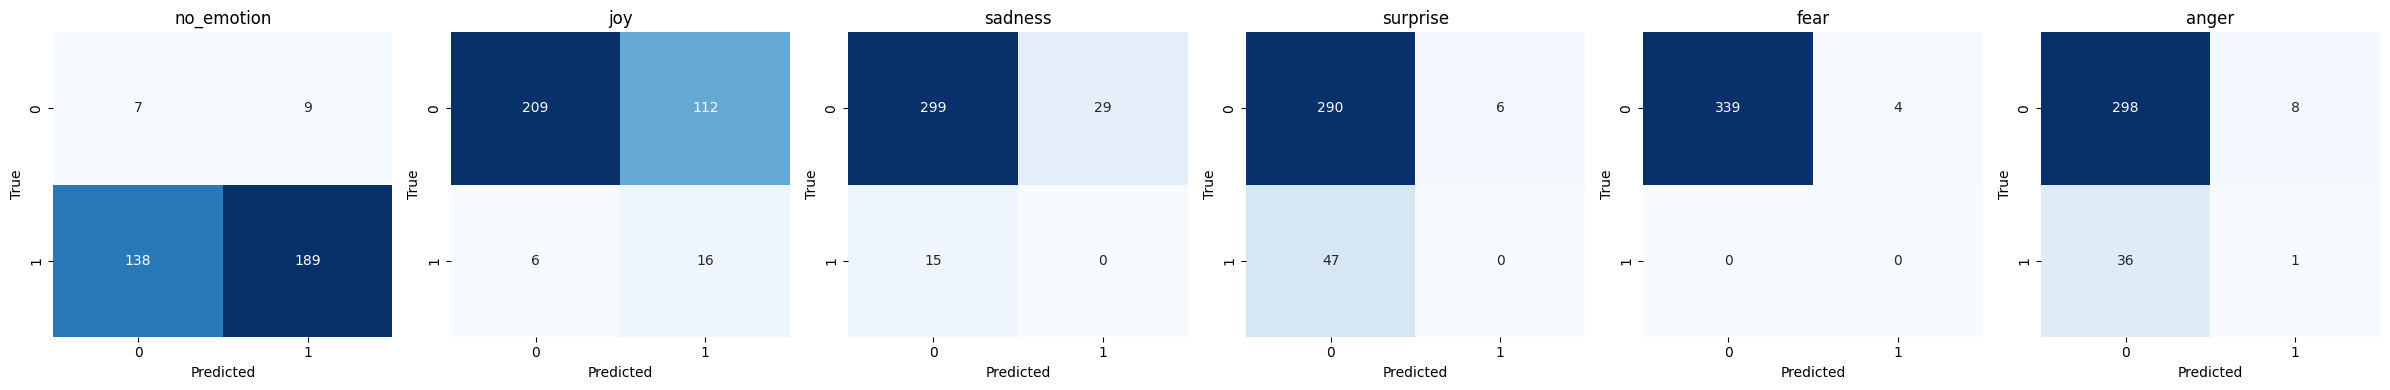

Device set to use cuda:0


Prediction: [[{'label': 'no_emotion', 'score': 0.01408832985907793}, {'label': 'joy', 'score': 0.9835302233695984}, {'label': 'sadness', 'score': 0.01516492385417223}, {'label': 'surprise', 'score': 0.012370861135423183}, {'label': 'fear', 'score': 0.007638067472726107}, {'label': 'anger', 'score': 0.010831735096871853}]]


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# –®–∞–≥ 1: –û–ø—Ä–µ–¥–µ–ª—è–µ–º —Å–ø–∏—Å–æ–∫ —ç–º–æ—Ü–∏–π (–∫–ª–∞—Å—Å–æ–≤)
EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']
df_test = pd.read_csv('eskis_test.csv')


# –ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏–º, —á—Ç–æ df_test —É–∂–µ –∑–∞–≥—Ä—É–∂–µ–Ω –∏ –∏–º–µ–µ—Ç —Å—Ç–æ–ª–±—Ü—ã:
# ["text", "Angry", "Disgusted", "Happy", "Neutral", "Sad", "Scared", "Surprised"]

# 1. –°–æ–∑–¥–∞—ë–º –Ω–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã, –æ–±—ä–µ–¥–∏–Ω—è—è "Angry" –∏ "Disgusted" -> "anger"
df_test["anger"] = (
    (df_test["Angry"] == 1) | (df_test["Disgusted"] == 1)
).astype(int)

# 2. –û—Å—Ç–∞–ª—å–Ω—ã–µ —ç–º–æ—Ü–∏–∏ –Ω–∞–ø—Ä—è–º—É—é –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º:
df_test["no_emotion"] = df_test["Neutral"]
df_test["joy"] = df_test["Happy"]
df_test["sadness"] = df_test["Sad"]
df_test["surprise"] = df_test["Surprised"]
df_test["fear"] = df_test["Scared"]

# 3. (–û–ø—Ü–∏–æ–Ω–∞–ª—å–Ω–æ) –£–¥–∞–ª—è–µ–º —Å—Ç–∞—Ä—ã–µ —Å—Ç–æ–ª–±—Ü—ã, –µ—Å–ª–∏ –æ–Ω–∏ –±–æ–ª—å—à–µ –Ω–µ –Ω—É–∂–Ω—ã:
df_test.drop(columns=["Angry","Disgusted","Happy","Neutral","Sad","Scared","Surprised"], inplace=True)

# 4. –§–æ—Ä–º–∏—Ä—É–µ–º –Ω–æ–≤—ã–π —Å–ø–∏—Å–æ–∫ —ç–º–æ—Ü–∏–π (—Å —É—á—ë—Ç–æ–º –Ω–æ–≤–æ–π —Å—Ö–µ–º—ã)
EMOTIONS = ["no_emotion", "joy", "sadness", "surprise", "fear", "anger"]

# 5. –°–æ–∑–¥–∞—ë–º —Å—Ç–æ–ª–±–µ—Ü "labels" —Å–æ —Å–ø–∏—Å–∫–æ–º 0/1 –¥–ª—è –∫–∞–∂–¥–æ–π –Ω–æ–≤–æ–π —ç–º–æ—Ü–∏–∏
df_test["labels"] = df_test[EMOTIONS].values.tolist()


classifier = pipeline(
    "text-classification",
    model='seara/rubert-tiny2-cedr-russian-emotion',
    return_all_scores=True
)

# –°–ø–∏—Å–∫–∏ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –∏ –∏—Å—Ç–∏–Ω–Ω—ã—Ö –º–µ—Ç–æ–∫
predictions = []
true_labels = []

# –®–∞–≥ 4: –ò–Ω—Ñ–µ—Ä–µ–Ω—Å –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ –≤ df_test
for _, row in df_test.iterrows():
    text = row["text"]
    # –ò—Å—Ç–∏–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ (—Å–ø–∏—Å–æ–∫ –∏–∑ 7 —ç–ª–µ–º–µ–Ω—Ç–æ–≤: 0 –∏–ª–∏ 1)
    true_labels.append(row["labels"])
    
    # –í—ã–∑—ã–≤–∞–µ–º pipeline –Ω–∞ —Ç–µ–∫—Å—Ç
    outputs = classifier(text)
    # outputs –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–ø–∏—Å–∫–æ–º —Å–ª–æ–≤–∞—Ä–µ–π –∏–ª–∏ —Å–ø–∏—Å–∫–æ–º —Å–ø–∏—Å–∫–æ–≤ —Å–ª–æ–≤–∞—Ä–µ–π
    # –ï—Å–ª–∏ –≤–µ—Ä–Ω—É–ª—Å—è —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤, –±–µ—Ä—ë–º –ø–µ—Ä–≤—ã–π —ç–ª–µ–º–µ–Ω—Ç
    if isinstance(outputs[0], list):
        outputs = outputs[0]
        
    # –ò–∑–≤–ª–µ–∫–∞–µ–º score –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É
    scores = [o["score"] for o in outputs]
    # –ë–∏–Ω–∞—Ä–∏–∑—É–µ–º –ø–æ –ø–æ—Ä–æ–≥—É 0.5
    pred = [1 if s > 0.2 else 0 for s in scores]
    predictions.append(pred)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ numpy –º–∞—Å—Å–∏–≤—ã –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞
y_true = np.array(true_labels)  # shape (num_samples, 7)
y_pred = np.array(predictions)  # shape (num_samples, 7)

# –®–∞–≥ 5: –í—ã–≤–æ–¥–∏–º –æ—Ç—á—ë—Ç –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ (precision, recall, f1-score) –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
report = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=0)
print("Classification Report:\n", report)

# –®–∞–≥ 6: –í—ã—á–∏—Å–ª—è–µ–º –∏ –≤–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –º–Ω–æ–≥–æ–º–µ—Ç–æ—á–Ω—ã–µ confusion matrices
mcm = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, len(EMOTIONS), figsize=(4 * len(EMOTIONS), 4))
if len(EMOTIONS) == 1:
    axes = [axes]  # –ï—Å–ª–∏ –≤–¥—Ä—É–≥ –æ–¥–∏–Ω –∫–ª–∞—Å—Å

for i, (cm, emotion) in enumerate(zip(mcm, EMOTIONS)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(emotion)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()
# 15. –ò–Ω—Ñ–µ—Ä–µ–Ω—Å: —Å–æ–∑–¥–∞–Ω–∏–µ pipeline –∏ –ø—Ä–∏–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
classifier = pipeline("text-classification", model='cointegrated/rubert-tiny2-cedr-emotion-detection', return_all_scores=True)
example_text = "—è —Å—á–∞—Å—Ç–ª–∏–≤!"
prediction = classifier(example_text)
print("Prediction:", prediction)


In [131]:
df_test

text  \
0    –æ—Ç —Å–≤–æ–∏—Ö —É—á–µ—Ç–Ω—ã—Ö –∑–∞–ø–∏—Å–µ–π –Ω–∞ –∫–æ–º–ø—å—é—Ç–µ—Ä–µ –ø–æ—Ç–æ–º—É ...   
1    –∏ –æ–¥–∏–Ω —Å –Ω–∞–∑—ã–≤–∞–µ—Ç—Å—è —è—á–µ–π–∫–∞ –∏–∫—Å –±–æ–∫–æ–≤–∞—è —Ç–∞–º –≥–¥–µ...   
2    —Ü–∏–∫–ª–æ–≥—Ä–∞–º–º—É –Ω–∞ —Å–µ–≥–æ–¥–Ω—è —á–µ—Ç—ã—Ä–µ –¥–Ω—è –±–ª–∏–∂–∞–π—à–∏—Ö –ø–æ...   
3     –Ω–æ —è –¥—É–º–∞—é —á—Ç–æ –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–µ–π –≤–æ–ø—Ä–æ—Å –æ —Ç–æ–º —á—Ç–æ –Ω...   
4    –∏–∫—Å –æ–¥–∏–Ω –∫–æ—Ç–æ—Ä—ã–π –Ω–µ—Ç—É –¥–µ–ª–æ –≤ —Ç–æ–º —á—Ç–æ —Å–∏—Å—Ç–µ–º–∞ –±...   
..                                                 ...   
340  –¥–æ–±—Ä–æ–µ —É—Ç—Ä–æ —É–≤–∞–∂–∞–µ–º–∞—è –¥–µ–∂—É—Ä–Ω–∞—è –±—Ä–∏–≥–∞–¥–∞ —ç—Ç–æ –ø–æ—Å...   
341  –≤ –æ–±—â–µ–º –º—ã –≥–æ—Ç–æ–≤—ã –∫ —Ä–∞–±–æ—Ç–µ –∏ –ø—Ä–∏—Å—Ç—É–ø–∞–µ–º –∫ –Ω–µ–π ...   
342  —Å–µ–≥–æ–¥–Ω—è –¥–ª—è –º–µ–Ω—è –¥–æ–≤–æ–ª—å–Ω–æ —Ç–∞–∫–∏ –ø—Ä–æ—Å—Ç–∞—è —Ü–∏–∫–ª–æ–≥—Ä...   
343  –Ω–µ –¥–∏–ø–∏—Å–∏ –±—ã–ª–æ –æ—á–µ–Ω—å –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ –∏ –º–Ω–µ –ø–æ–Ω—Ä–∞–≤–∏–ª–æ...   
344  –≥–æ—Ç–æ–≤–∞ —Ä–∞–±–æ—Ç–∞—Ç—å –ø–æ —Ü–∏–∫–ª–æ–≥—Ä–∞–º–º–µ –≤—Å–µ–º —Å–ø–∞—Å–∏–±–æ —Ö–æ...   

                                  labels  anger  no_emotion  joy  sadness  \
0    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
1    [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]      0         1.0  0.0      1.0   
2    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
3    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
4    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
..                                   ...    ...         ...  ...      ...   
340  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
341  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   
342  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]      0         0.0  0.0      0.0   
343  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]      0         1.0  0.0      0.0   
344  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]      0         1.0  0.0      0.0   

     surprise  fear  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
..        ...   ...  
340       0.0   0.0  
341       0.0   0.0  
342       1.0   0.0  
343       1.0   0.0  
344       0.0   0.0  

[343 rows x 8 columns]

In [125]:
import mlflow.pytorch
from transformers import AutoTokenizer, pipeline

# –ó–∞–¥–∞–π—Ç–µ –ø—É—Ç—å –∫ —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è "model", –∫–∞–∫ –±—ã–ª–æ —É–∫–∞–∑–∞–Ω–æ –ø—Ä–∏ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–∏)
model_uri = "./smp"

# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏–∑ MLflow
loaded_model = mlflow.pytorch.load_model(model_uri)

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–π –∏—Å–ø–æ–ª—å–∑—É–µ–º–æ–π –º–æ–¥–µ–ª–∏
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_uri)

# –°–æ–∑–¥–∞–µ–º pipeline –¥–ª—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
classifier = pipeline("text-classification", model=loaded_model, return_all_scores=True)



MlflowException: Model does not have the "pytorch" flavor

In [ ]:
import mlflow.pytorch
from transformers import AutoTokenizer, pipeline

# –ó–∞–¥–∞–π—Ç–µ –ø—É—Ç—å –∫ —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è "model", –∫–∞–∫ –±—ã–ª–æ —É–∫–∞–∑–∞–Ω–æ –ø—Ä–∏ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–∏)
model_uri = "./smp"


# –°–æ–∑–¥–∞–µ–º pipeline –¥–ª—è –∏–Ω—Ñ–µ—Ä–µ–Ω—Å–∞
classifier =  mlflow.transformers.load_model(model_uri) 


2025/03/12 18:26:56 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


In [ ]:
# –ü—Ä–∏–º–µ—Ä —Ç–µ–∫—Å—Ç–∞ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
example_text = "–Ø —Å—á–∞—Å—Ç–ª–∏–≤"
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
# –í—ã–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
prediction = classifier(example_text, return_all_scores=True)

prediction = list(map(lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } if pred.get("label", "").startswith("LABEL_") else pred, prediction[0]))
print("Prediction:", prediction)

Prediction: [{'label': 'anger', 'score': 0.013769811019301414}, {'label': 'disgust', 'score': 0.008547131903469563}, {'label': 'fear', 'score': 0.00553023861721158}, {'label': 'joy', 'score': 0.9261977076530457}, {'label': 'sadness', 'score': 0.011247304268181324}, {'label': 'surprise', 'score': 0.018123449757695198}, {'label': 'neutral', 'score': 0.016584303230047226}]


In [ ]:
# –ü—Ä–∏–º–µ—Ä —Ç–µ–∫—Å—Ç–∞ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
example_text = "–Ø —Å—á–∞—Å—Ç–ª–∏–≤"
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
# –í—ã–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
prediction = classifier(example_text, return_all_scores=True)

prediction = {EMOTIONS[i]: round(prediction[0][i]['score'], 4) for i in range(len(EMOTIONS))} #   map(lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } if pred.get("label", "").startswith("LABEL_") else pred, prediction[0])
print("Prediction:", prediction)


Prediction: {'anger': 0.0138, 'disgust': 0.0085, 'fear': 0.0055, 'joy': 0.9262, 'sadness': 0.0112, 'surprise': 0.0181, 'neutral': 0.0166}


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:

prediction[0][0]['score']

0.013769811019301414

In [ ]:
import mlflow.transformers
from transformers import pipeline

EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

# –ó–∞–¥–∞–π—Ç–µ URI –º–æ–¥–µ–ª–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, "model" –∏–ª–∏ "runs:/<run_id>/model")
model_uri = "./smp"

# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–π pipeline
classifier = mlflow.transformers.load_model(model_uri)

example_text = "–Ø —Å—á–∞—Å—Ç–ª–∏–≤"

# –í—ã–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
predictions = classifier(example_text)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–º–µ–Ω—ã —è—Ä–ª—ã–∫–æ–≤ –≤ –æ–¥–Ω–æ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–∏ (—Å–ª–æ–≤–∞—Ä–µ)
replace_label = lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } \
    if isinstance(pred, dict) and pred.get("label", "").startswith("LABEL_") else pred

# –ï—Å–ª–∏ pipeline –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ —Å–ª–æ–≤–∞—Ä–µ–π
if predictions and isinstance(predictions[0], dict):
    converted = list(map(replace_label, predictions))
# –ï—Å–ª–∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç—Å—è —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤ —Å–ª–æ–≤–∞—Ä–µ–π
elif predictions and isinstance(predictions[0], list):
    converted = list(map(lambda group: list(map(replace_label, group)), predictions))
else:
    converted = predictions

print("Predictions:", converted)

2025/03/12 16:14:42 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


Predictions: [{'label': 'joy', 'score': 0.9261977076530457}]


In [ ]:

# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–æ—Ö—Ä–∞–Ω—ë–Ω–Ω—ã–π pipeline
classifier = mlflow.transformers.load_model(model_uri, return_all_scores=True)

example_text = "–Ø —Å—á–∞—Å—Ç–ª–∏–≤"

# –í—ã–ø–æ–ª–Ω—è–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
predictions = classifier(example_text)

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–º–µ–Ω—ã —è—Ä–ª—ã–∫–∞ –Ω–∞ –∏–º—è —ç–º–æ—Ü–∏–∏
def replace_label(pred):
    if isinstance(pred, dict) and pred.get("label", "").startswith("LABEL_"):
        idx = int(pred["label"][6:])  # –ò–∑–≤–ª–µ–∫–∞–µ–º —á–∏—Å–ª–æ –ø–æ—Å–ª–µ "LABEL_"
        pred["label"] = EMOTIONS[idx]
    return pred

# –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –≤—Å–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:
# –ï—Å–ª–∏ predictions ‚Äì —Å–ø–∏—Å–æ–∫ —Å–ª–æ–≤–∞—Ä–µ–π, —Ç–æ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –µ–≥–æ –Ω–∞–ø—Ä—è–º—É—é,
# –µ—Å–ª–∏ —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤, —Ç–æ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –∫–∞–∂–¥—É—é –≥—Ä—É–ø–ø—É –æ—Ç–¥–µ–ª—å–Ω–æ.
if predictions and isinstance(predictions[0], dict):
    converted = [replace_label(pred) for pred in predictions]
elif predictions and isinstance(predictions[0], list):
    converted = [ [ replace_label(pred) for pred in group ] for group in predictions ]
else:
    converted = predictions

print("All predictions:", converted)

2025/03/12 16:18:28 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


All predictions: [[{'label': 'anger', 'score': 0.013769811019301414}, {'label': 'disgust', 'score': 0.008547131903469563}, {'label': 'fear', 'score': 0.00553023861721158}, {'label': 'joy', 'score': 0.9261977076530457}, {'label': 'sadness', 'score': 0.011247304268181324}, {'label': 'surprise', 'score': 0.018123449757695198}, {'label': 'neutral', 'score': 0.016584303230047226}]]


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
